In [ ]:
# -*- coding: utf-8 -*-
"""Enhanced Sectoral Bottom-Up Simulation with Comprehensive Testing"""

# import numpy as np
# import scipy
# from scipy.stats import nct, ncx2, kstest, norm
# from scipy.special import hyp1f1
# import matplotlib.pyplot as plt
# import pandas as pd
# from scipy.stats import kurtosis, pearsonr
# from typing import Tuple, List, Optional
# import logging



import math
import numpy as np
import scipy
from scipy.stats import nct, ncx2, kstest, norm
from scipy.special import hyp1f1
import sys
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kurtosis, pearsonr
from typing import Tuple, List, Optional, Dict
import logging
from dataclasses import dataclass
from scipy.stats import kurtosis




# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [ ]:
class SectoralCIRSimulator:
    """Simulator for sectoral CIR model with default events"""

    def __init__(self, kappa: np.ndarray, theta: np.ndarray, sigma: np.ndarray,
                 n_firms: int, n_sectors: int):
        """
        Initialize the CIR simulator

        Parameters:
        -----------
        kappa : np.ndarray
            Mean reversion rates for each sector
        theta : np.ndarray
            Long-term means for each sector
        sigma : np.ndarray
            Volatilities for each sector
        n_firms : int
            Number of firms
        n_sectors : int
            Number of sectors
        """
        self.kappa = np.asarray(kappa)
        self.theta = np.asarray(theta)
        self.sigma = np.asarray(sigma)
        self.n_firms = n_firms
        self.n_sectors = n_sectors

        self._validate_parameters()
        self._check_feller_condition()

    def _validate_parameters(self):
        """Validate input parameters"""
        for param_name, param in zip(['kappa', 'theta', 'sigma'],
                                   [self.kappa, self.theta, self.sigma]):
            if len(param) != self.n_sectors:
                raise ValueError(f"{param_name} must have length {self.n_sectors}")
            if np.any(param <= 0):
                raise ValueError(f"{param_name} must be positive")

    def _check_feller_condition(self):
        """Check Feller condition for CIR process"""
        feller_ratio = (2 * self.kappa * self.theta) / (self.sigma ** 2)
        if np.all(feller_ratio >= 1):
            logger.info("Feller condition is satisfied for all sectors.")
        else:
            logger.warning("Feller condition is not satisfied for some sectors.")
            logger.warning(f"Feller ratios: {feller_ratio}")

    @staticmethod
    def lambda_max_generator(epsilon: float, y: float, theta: float, sigma: float,
                           kappa: float, max_attempts: int = 10, tol: float = 1e-8) -> float:
        """
        Compute H^*_epsilon such that P_y(sigma_H < tau) = G_y(H; H) <= epsilon.

        Implements Equation (11) using the closed-form in Equation (19).
        """
        def G_y(H: float) -> float:
            a = H / kappa
            b = 2 * kappa * theta / (sigma ** 2)
            z_y = 2 * kappa * y / (sigma ** 2)
            z_H = 2 * kappa * H / (sigma ** 2)
            num = hyp1f1(a, b, z_y)
            denom = hyp1f1(a, b, z_H)
            return num / denom

        def root_function(H: float) -> float:
            return G_y(H) - epsilon

        # Bracketing interval
        H_min = y + tol
        H_max = y + 10.0

        # Try to find root using numerical solver
        for attempt in range(max_attempts):
            try:
                H_star = scipy.optimize.toms748(root_function, H_min, H_max, xtol=tol)
                if root_function(H_star) <= 0:
                    return H_star
                else:
                    # Adjust if root function is still positive
                    H_star += 0.01
                    while root_function(H_star) > 0 and H_star < H_max + 5.0:
                        H_star += 0.01
                    return H_star
            except (ValueError, RuntimeError) as e:
                logger.debug(f"Attempt {attempt + 1} failed: {e}")
                H_max += 5.0

        # Fallback: grid search
        logger.warning("Root finding failed. Using fallback grid search.")
        H_vals = np.linspace(H_min, H_max + 50, 2000)
        for H in H_vals:
            if G_y(H) <= epsilon:
                return H

        raise RuntimeError(f"Unable to find H^*_epsilon for epsilon={epsilon}. Try expanding search space.")

    def simulate_default_events(self, T: float, W: np.ndarray, delta: np.ndarray,
                              idiosyncratic_factor: np.ndarray, epsilon: float,
                              low: float = 0.0, high: float = 1.0) -> Tuple[np.ndarray, ...]:
        """
        Simulate default events using Algorithm 3.2 from Giesecke 2013.

        Parameters:
        -----------
        T : float
            Time to maturity
        W : np.ndarray
            Sector weight matrix (n_firms × n_sectors)
        delta : np.ndarray
            Impact matrix (n_firms × n_sectors)
        idiosyncratic_factor : np.ndarray
            Firm-specific default factors
        epsilon : float
            Tolerance parameter
        low, high : float
            Uniform distribution bounds for loss marks

        Returns:
        --------
        events : np.ndarray
            Default event times
        marks : np.ndarray
            Loss marks for each default
        defaulter_idio_factor : np.ndarray
            Idiosyncratic factors of defaulters
        defaulter_sector_decomposition : np.ndarray
            Sector contributions for defaulters
        """
        # Precompute lambda benchmark
        lambda_benchmark = np.array([
            self.lambda_max_generator(epsilon, self.theta[i], self.theta[i],
                                    self.sigma[i], self.kappa[i])
            for i in range(self.n_sectors)
        ])

        t = 0.0
        lambda_t = self.theta.copy()
        gamma = self.theta.copy()

        events = []
        marks = []
        defaulter_idio_factor = []
        defaulter_sector_decomposition = []

        # Initialize active firms
        active_firms = np.arange(self.n_firms)

        while t < T and len(active_firms) > 0:
            # Compute lambda_max efficiently
            mask = lambda_t <= gamma
            lambda_max = np.where(mask, lambda_benchmark, lambda_t + lambda_benchmark - gamma)

            # Compute systemic and idiosyncratic parts
            systemic_part = np.sum(np.dot(W[active_firms], lambda_max))
            idiosyncratic_part = np.sum(idiosyncratic_factor[active_firms])
            H_epsilon = systemic_part + idiosyncratic_part

            # Generate next event time
            tau = np.random.exponential(1.0 / H_epsilon)
            t_proposed = t + tau

            if t_proposed >= T:
                break

            # Update lambda values
            exp_kappa_tau = np.exp(-self.kappa * tau)
            one_minus_exp = 1 - exp_kappa_tau
            c = self.sigma**2 * one_minus_exp / (4 * self.kappa)
            df = 4 * self.kappa * self.theta / (self.sigma**2)
            nc = 4 * self.kappa * lambda_t * exp_kappa_tau / (self.sigma**2 * one_minus_exp)

            lambda_proposedf = c * ncx2.rvs(df, nc, size=len(df))
            lambda_proposed = (np.sum(np.dot(W[active_firms], lambda_proposedf)) +
                             np.sum(idiosyncratic_factor[active_firms]))

            # Acceptance test
            acceptance_prob = min(lambda_proposed / H_epsilon, 1.0)

            if np.random.uniform() < acceptance_prob:
                # Accept proposed event
                t = t_proposed
                events.append(t)

                # Select defaulting firm
                probs = (idiosyncratic_factor[active_firms] +
                        np.dot(W[active_firms], lambda_proposedf)) / lambda_proposed
                probs = np.clip(probs, 0, None)  # Ensure non-negative
                probs /= np.sum(probs)  # Normalize

                selected_idx = np.random.choice(len(active_firms), p=probs)
                selected_defaulter = active_firms[selected_idx]

                # Update active firms
                active_firms = np.delete(active_firms, selected_idx)

                # Record default information
                defaulter_idio_factor.append(idiosyncratic_factor[selected_defaulter])
                defaulter_sector_decomposition.append(W[selected_defaulter])

                # Generate loss mark
                mark = np.random.uniform(low, high)


                # Update lambda_t with impact
                lambda_t = lambda_proposedf + delta[selected_defaulter] * mark
                marks.append(mark)
            else:
                # Reject event
                t = t_proposed
                lambda_t = lambda_proposedf

        return (np.array(events), np.array(marks),
                np.array(defaulter_idio_factor), np.array(defaulter_sector_decomposition))


In [ ]:
import numpy as np

def create_sector_weights(
    n_firms: int,
    n_sectors: int,
    concentration_type,
    balanced_mode='exact',
    balanced_concentration=100.0,
    dominant_sector: int = 0,
    randomize_dominant: bool = True,
    dominant_share: float = 0.6,
    concentration_strength: float = 100.0
) -> np.ndarray:
    """
    Create sector weight matrices with different concentration patterns.

    Parameters
    ----------
    n_firms : int
        Number of firms.
    n_sectors : int
        Number of sectors.
    concentration_type : str
        Pattern of sectoral exposure:
        - "concentrated": Each firm group is heavily concentrated in one sector.
        - "balanced": Each firm equally exposed across all sectors.
        - "mixed": One dominant sector, others equally less dominant.
    dominant_sector : int or None, optional
        Index (0-based) of the dominant sector for 'mixed' pattern.
        If None and randomize_dominant=True, chosen randomly.
    randomize_dominant : bool
        If True, randomize dominant sector assignments when relevant.

    Returns
    -------
    W : np.ndarray of shape (n_firms, n_sectors)
        Sector weight matrix (rows sum to 1).
    """

    if n_sectors < 1:
        raise ValueError("n_sectors must be >= 1")

    # --- Concentrated: assign groups of firms to different dominant sectors ---
    if concentration_type.lower() == "concentrated":
        if n_sectors < 1:
            raise ValueError("n_sectors must be >= 1")
        if not (0 < dominant_share < 1):
            raise ValueError("dominant_share must be in (0,1)")
        if not (0 <= dominant_sector < n_sectors):
            raise ValueError("dominant_sector index out of range")

        # target mean vector
        if n_sectors == 1:
            target = np.array([1.0])
        else:
            other_share = (1.0 - dominant_share) / (n_sectors - 1)
            target = np.full(n_sectors, other_share)
            target[dominant_sector] = dominant_share

        # alpha for Dirichlet (scale target by concentration_strength)
        alpha = target * concentration_strength

        # sample n_firms independent Dirichlet draws
        W = np.random.dirichlet(alpha, size=n_firms)
        #print(W[0:10])
    # --- Balanced: equal exposure across all sectors ---
    elif concentration_type.lower() == "balanced":
        if balanced_mode == 'exact':
            W = np.tile(np.ones(n_sectors)/n_sectors, (n_firms,1))
        elif balanced_mode == 'near':
            alpha = np.full(n_sectors, balanced_concentration)
            W = np.random.dirichlet(alpha, size=n_firms)
        elif balanced_mode == 'random':
            alpha = np.ones(n_sectors)  # or alpha=2 for moderate
            W = np.random.dirichlet(alpha, size=n_firms)
        else:
            raise ValueError("balanced_mode must be 'exact', 'near' or 'random'")
        #print(W[0:10])
    # --- Mixed: one dominant sector, others equal ---
    elif concentration_type.lower() == "mixed":
        if dominant_sector is None and randomize_dominant:
            dominant_sector = np.random.randint(0, n_sectors)
        elif dominant_sector is None:
            dominant_sector = 0  # fallback default

        alpha = np.full(n_sectors, 2.0)
        alpha[dominant_sector] = 3.0  # heavier weight to chosen sector
        W = np.random.dirichlet(alpha, size=n_firms)
        #print(W[0:10])
    else:
        raise ValueError("concentration_type must be 'concentrated', 'balanced', or 'mixed'")

    return W


# Alternative function if you want to generate all three types at once
def create_all_sector_weight_scenarios(n_firms: int, n_sectors: int) -> List[np.ndarray]:
    """
    Create all three concentration scenarios at once

    Returns:
    --------
    W_list : List[np.ndarray]
        List of weight matrices in order: [concentrated, balanced, mixed]
    """
    W_list = []

    # Concentrated: one dominant sector
    W_conc = create_sector_weights(n_firms, n_sectors, "concentrated")
    W_list.append(W_conc)

    # Balanced: equal weights
    W_bal = create_sector_weights(n_firms, n_sectors, "balanced")
    W_list.append(W_bal)

    # Mixed: one dominant, others equal
    W_mixed = create_sector_weights(n_firms, n_sectors, "mixed")
    W_list.append(W_mixed)

    #print(W_list)

    return W_list

def calculate_expected_shortfall(losses: np.ndarray, alpha: float = 0.95) -> float:
    """
    Calculate Expected Shortfall (CVaR) at confidence level alpha
    """
    # Calculate VaR (Value at Risk) at alpha level
    var = np.quantile(losses, alpha)

    # Expected Shortfall is the average of losses exceeding VaR
    tail_losses = losses[losses >= var]

    if len(tail_losses) > 0:
        es = np.mean(tail_losses)
    else:
        es = var  # Fallback if no losses exceed VaR

    return es

def plot_loss_distribution(losses: np.ndarray, label: str, ax: plt.Axes, bins: int = 10):
    """
    Plot loss distribution with smooth interpolation

    Parameters:
    -----------
    losses : np.ndarray
        Array of loss values
    label : str
        Label for the plot
    ax : plt.Axes
        Matplotlib axes object
    bins : int
        Number of histogram bins
    """
    # Get histogram data (without plotting)
    counts, bin_edges = np.histogram(losses, bins=bins, density=True)

    # Get bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Interpolation function
    f_interp = interp1d(bin_centers, counts, kind='cubic', fill_value="extrapolate")

    # New x-values for smooth curve
    x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 500)
    y_smooth = f_interp(x_smooth)

    # Plot histogram and interpolated curve
    ax.hist(losses, bins=50, density=True, alpha=0.4)
    ax.plot(x_smooth, y_smooth, label=label, linewidth=2)

    ax.set_xlabel('Loss')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

Model Analysis

In [ ]:
T = 1 # observation window (use consistently)

N_FIRMS = 1000
J = 3
NUM_TRIALS = 2500
theta_sector = np.random.uniform(0.001, 0.051, J)
kappa_sector = np.random.uniform(0.5, 1.5, J)      # mean reversion
sigma_sector = np.minimum(np.sqrt(2*theta_sector*kappa_sector),np.random.uniform(0.0, 0.2, J))#np.random.uniform(0.02, 0.04, J)    # Lower volatility
idiosyncratic_factors = np.random.uniform(0.01,0.03,N_FIRMS)#0.01*np.ones(N_FIRMS)

W_list = create_all_sector_weight_scenarios(N_FIRMS, J)
#print(W_list)
config_names = ["Concentrated", "Balanced", "Mixed"]
# Option 2: Reduced impact]
delta_list = [0.01 * W for W in W_list]



--- Concentrated ---
Mean defaults: 119.1 out of 1000 firms
Default rate: 11.91%
Mean loss: 59.5677
Loss std: 18.2216
Excess Kurtosis: 0.1273
95% Quantile: 91.6667
Expected Shortfall (95%): 101.6941

--- Balanced ---
Mean defaults: 83.6 out of 1000 firms
Default rate: 8.36%
Mean loss: 41.8185
Loss std: 11.8147
Excess Kurtosis: 0.1499
95% Quantile: 62.2342
Expected Shortfall (95%): 68.9923

--- Mixed ---
Mean defaults: 89.7 out of 1000 firms
Default rate: 8.97%
Mean loss: 44.9061
Loss std: 12.9456
Excess Kurtosis: 0.1853
95% Quantile: 68.0071
Expected Shortfall (95%): 74.7190


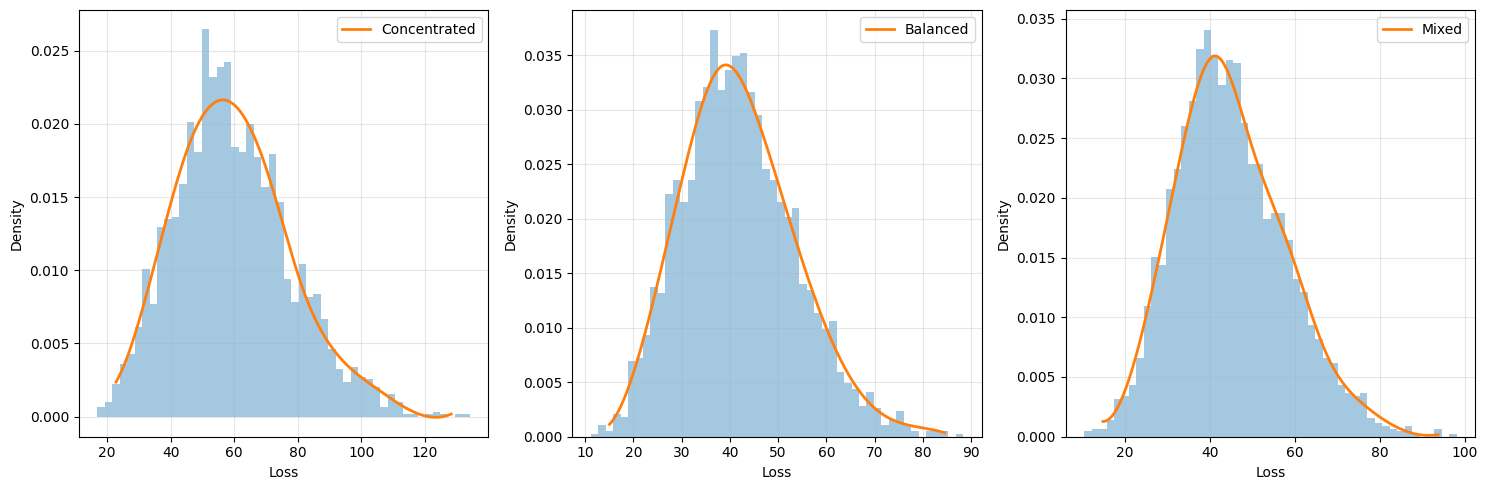

In [ ]:
# Test 1- Limit Case Analysis
# Heavy-Tailed Loss distribution - Verifying the loss distribution exhinits fat tail.
#np.random.seed(42)
epsilon = 1.0 / 2500#NUM_TRIALS
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Create sector weights
#W_list = create_all_sector_weight_scenarios(N_FIRMS, J)
config_names = ["Concentrated", "Balanced", "Mixed"]
simulator = SectoralCIRSimulator(kappa_sector, theta_sector, sigma_sector, N_FIRMS, J)
for i, (W, delta, config_name) in enumerate(zip(W_list, delta_list, config_names)):
    #logger.info(f"Running simulation for configuration: {config_name}")

    losses = np.zeros(NUM_TRIALS)
    default_counts = np.zeros(NUM_TRIALS)

    for trial in range(NUM_TRIALS):
        #if trial % 10 == 0:
            #logger.info(f"Trial {trial + 1}/{NUM_TRIALS}")

        events, marks, _, _ = simulator.simulate_default_events(
            T, W, delta, idiosyncratic_factors, epsilon
        )
        losses[trial] = np.sum(marks)
        default_counts[trial] = len(events)

    # Print comprehensive statistics
    mean_defaults = np.mean(default_counts)

    default_rate = mean_defaults / N_FIRMS



    print(f"\n--- {config_name} ---")
    print(f"Mean defaults: {mean_defaults:.1f} out of {N_FIRMS} firms")
    print(f"Default rate: {default_rate:.2%}")
    print(f"Mean loss: {np.mean(losses):.4f}")
    print(f"Loss std: {np.std(losses):.4f}")
    print(f"Excess Kurtosis: {kurtosis(losses):.4f}")
    print(f"95% Quantile: {np.quantile(losses, 0.95):.4f}")
    print(f"Expected Shortfall (95%): {calculate_expected_shortfall(losses, 0.95):.4f}")

    # Plot loss distribution
    if len(losses) > 0 and np.max(losses) > 0:
        plot_loss_distribution(losses, config_name, axes[i])
    else:
        axes[i].text(0.5, 0.5, f"No defaults\nin {config_name}",
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_xlabel('Loss')
        axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()


In [ ]:
# # Synthetic example: simulate marked Hawkes process (exponential kernel) and calibrate parameters by MLE
# # This code will:
# # 1. Simulate a marked Hawkes process on [0, T] using Ogata's thinning algorithm.
# # 2. Fit parameters (mu, alpha, beta, gamma) by maximizing the log-likelihood using scipy.optimize.
# #    - Kernel: phi(t) = alpha * exp(-beta t)
# #    - Mark effect: multiplicative factor = exp(gamma * mark_i)
# #    => intensity: lambda(t) = mu + sum_{t_j < t} alpha * exp(gamma * mark_j) * exp(-beta (t - t_j))
# # 3. Print true vs estimated parameters and plot the event times and estimated vs true intensity.
# #
# # Notes:
# # - The code is vectorized for clarity; for very large event counts you may need further optimization.
# # - If scipy is not available in the execution environment, the optimizer will fallback to simple Nelder-Mead.
# # - The plot uses matplotlib (single plot) without explicit color settings per tool guidance.
# #
# # Run to see a complete worked example.

# import numpy as np
# from math import exp
# import matplotlib.pyplot as plt

# # Try importing scipy; if absent, we'll use a fallback optimizer
# try:
#     from scipy.optimize import minimize
#     SCIPY_AVAILABLE = True
# except Exception as e:
#     from functools import partial
#     SCIPY_AVAILABLE = False
#     print("scipy not available; optimizer will use a simple Nelder-Mead fallback.")

# np.random.seed(42)

# def simulate_marked_hawkes(mu, alpha, beta, gamma, T, mark_sampler):
#     """
#     Simulate marked Hawkes process with exponential kernel using Ogata's thinning.
#     mark_sampler: function that returns a mark value when called (e.g., lambda: np.random.exponential(1.0))
#     Returns: times (numpy array), marks (numpy array)
#     """
#     times = []
#     marks = []
#     t = 0.0
#     # upper bound for conditional intensity to use in thinning; we'll adaptively set it
#     # We'll compute current intensity exactly when needed
#     while True:
#         # compute current intensity lambda(t)
#         if len(times) == 0:
#             lam_t = mu
#         else:
#             s = np.array(times)
#             m = np.array(marks)
#             lam_t = mu + np.sum(alpha * np.exp(gamma * m) * np.exp(-beta * (t - s)))
#         # sample next candidate from exponential with rate lam_t
#         if lam_t <= 0:
#             # degenerate; stop
#             break
#         u = np.random.rand()
#         w = -np.log(u) / lam_t
#         t_candidate = t + w
#         if t_candidate > T:
#             break
#         # compute intensity at candidate time
#         if len(times) == 0:
#             lam_candidate = mu
#         else:
#             lam_candidate = mu + np.sum(alpha * np.exp(gamma * np.array(marks)) * np.exp(-beta * (t_candidate - np.array(times))))
#         # thinning
#         D = np.random.rand()
#         if D * lam_t <= lam_candidate:
#             # accept
#             t = t_candidate
#             times.append(t)
#             marks.append(mark_sampler())
#         else:
#             t = t_candidate
#     return np.array(times), np.array(marks)


# def log_likelihood(params, times, marks, T, penalize=False):
#     """
#     Negative log-likelihood (for minimization).
#     params: [mu, alpha, beta, gamma]
#     """
#     mu, alpha, beta, gamma = params
#     # enforce positivity where needed by returning large penalty
#     if mu <= 0 or alpha < 0 or beta <= 0:
#         return 1e12 + 1e6 * (abs(mu) + abs(alpha) + abs(beta))
#     n = len(times)
#     if n == 0:
#         # if no events, LL = -mu * T (up to sign); so negative log-lik = mu * T
#         return mu * T
#     # Precompute mark factors
#     mark_factors = np.exp(gamma * marks)
#     # Compute intensity at each event: lambda_i = mu + sum_{j < i} alpha * mark_j * exp(-beta (t_i - t_j))
#     lam_at_events = np.empty(n)
#     # We'll efficiently compute using cumulative sums exponentials
#     for i in range(n):
#         if i == 0:
#             lam_at_events[i] = mu
#         else:
#             dt = times[i] - times[:i]
#             lam_at_events[i] = mu + alpha * np.sum(mark_factors[:i] * np.exp(-beta * dt))
#         # numerical safety
#         if lam_at_events[i] <= 0:
#             return 1e12
#     # Log-likelihood: sum log(lambda_i) - integral_0^T lambda(t) dt
#     ll_sum = np.sum(np.log(lam_at_events))
#     # Integral of intensity = mu * T + (alpha / beta) * sum_j mark_j * (1 - exp(-beta (T - t_j)))
#     integral = mu * T + (alpha / beta) * np.sum(mark_factors * (1.0 - np.exp(-beta * (T - times))))
#     neg_ll = -(ll_sum - integral)
#     # optional small penalty to keep parameters in reasonable range
#     if penalize:
#         neg_ll += 1e-6 * np.sum(np.square(params))
#     return neg_ll


# def fit_hawkes_mle(times, marks, T, init_guess=None, bounds=None):
#     if init_guess is None:
#         # crude initialization
#         mu0 = max(1e-3, 0.5 * len(times) / T)
#         alpha0 = 0.5
#         beta0 = 1.0
#         gamma0 = 0.0
#         init_guess = np.array([mu0, alpha0, beta0, gamma0])
#     if bounds is None:
#         # mu>0, alpha>=0, beta>0, gamma unbounded
#         bounds = [(1e-9, None), (0.0, None), (1e-9, None), (None, None)]
#     if SCIPY_AVAILABLE:
#         res = minimize(lambda x: log_likelihood(x, times, marks, T, penalize=True),
#                        init_guess, bounds=bounds, method='L-BFGS-B',
#                        options={'maxiter': 1000})
#         return res.x, res
#     else:
#         # fallback to Nelder-Mead without bounds (may give invalid params)
#         res = minimize(lambda x: log_likelihood(x, times, marks, T, penalize=True),
#                        init_guess, method='Nelder-Mead', options={'maxiter': 2000})
#         return res.x, res




In [ ]:
# events_list = []
# marks_list = []
# from matplotlib.colors import Normalize
# import matplotlib.cm as cm
# np.random.seed(42)

# T = 1 # observation window (use consistently)

# N_FIRMS = 1000
# J = 3

# theta_sector = np.random.uniform(0.001, 0.051, J) #np.array([0.1, 0.15, 0.2])  # 1-2% baseline intensity
# kappa_sector = np.random.uniform(0.5, 1.5, J)      # Faster mean reversion
# sigma_sector = np.minimum(np.sqrt(2*theta_sector*kappa_sector),np.random.uniform(0.02, 0.04, J))#np.random.uniform(0.02, 0.04, J)    # Lower volatility
# idiosyncratic_factors = np.random.uniform(0.01,0.03,N_FIRMS)#0.01*np.ones(N_FIRMS)

# W_list = create_all_sector_weight_scenarios(N_FIRMS, J)
# config_names = ["Concentrated", "Balanced", "Mixed"]
# # Option 2: Reduced impact]
# delta_list = [0.01 * W for W in W_list]

# for i, (W, delta, config_name) in enumerate(zip(W_list, delta_list, config_names)):
#     events, marks, _, _ = simulator.simulate_default_events(
#         T, W, delta, idiosyncratic_factors, 1/500
#     )
#     print(len(events))
#     # events_list.append(events)
#     # marks_list.append(marks)
#     init_guess = np.array([0.2, 0.4, 1.0, 1.0])
#     est_params, res_obj = fit_hawkes_mle(events, marks, T=1, init_guess=init_guess)
#     mu_hat, alpha_hat, beta_hat, gamma_hat = est_params

#     print("\nTrue parameters vs Estimated:")
#     print(f"mu    : {mu_hat:.4f}")
#     print(f"alpha : {alpha_hat:.4f}")
#     print(f"beta  : {beta_hat:.4f}")
#     print(f"gamma : {gamma_hat:.4f}")


#     times = events

#     if SCIPY_AVAILABLE:
#         print("\nOptimizer success:", res_obj.success)
#         print("Optimizer message:", res_obj.message)

#     # Plot events and intensity using true and estimated params
#     def intensity_over_time(t_grid, times, marks, mu, alpha, beta, gamma):
#         vals = np.ones_like(t_grid) * mu
#         for tj, mj in zip(times, marks):
#             mask = t_grid >= tj
#             if np.any(mask):
#                 vals[mask] += alpha * np.exp(gamma * mj) * np.exp(-beta * (t_grid[mask] - tj))
#         return vals

#     # sizing and colormap scale
#     mark_min, mark_max = (marks.min(), marks.max()) if len(marks)>0 else (0.0,1.0)
#     # scale marker sizes for visible bubbles
#     size_scale = 300 # adjust if marks are small/large
#     marker_sizes = size_scale * (marks - mark_min) / max(1e-12, (mark_max - mark_min))

#     # plotting grid
#     tgrid = np.linspace(0.0, T, 1000)
#     lam_est = intensity_over_time(tgrid, times, marks, mu_hat, alpha_hat, beta_hat, gamma_hat)

#     fig, axes = plt.subplots(2, 1, figsize=(14, 5.5), gridspec_kw={'height_ratios':[1,2]}, sharex=True)
#     ax_top, ax_bot = axes

#     # ---------------- Top: timeline of events ----------------
#     y = np.ones_like(times) * 1.0
#     sc = ax_top.scatter(times, y, s=marker_sizes, c=marks, cmap='viridis', alpha=0.9, edgecolors='k', linewidth=0.25)
#     ax_top.set_yticks([])                     # hide y-axis ticks
#     ax_top.set_ylim(0.92, 1.06)
#     ax_top.set_title('Hawkes Process Timeline with Marks '+config_name)
#     ax_top.set_xlabel('Time')
#     # colorbar placed on right of top plot
#     cbar = plt.colorbar(sc, ax=ax_top, orientation='vertical', pad=0.02)
#     cbar.set_label('Mark Size (Loss Amount)')
#     ax_top.grid(axis='x', linestyle=':', linewidth=0.6)

#     # ---------------- Bottom: intensity and events ----------------
#     ax_bot.plot(tgrid, lam_est, linewidth=2.0, label='Estimated Intensity', color='tab:blue')
#     # overlay event markers at event times with same color/size mapping
#     # compute intensity at event times for nicer marker placement
#     lam_at_events = intensity_over_time(times, times, marks, mu_hat, alpha_hat, beta_hat, gamma_hat)
#     # draw small circle markers with edge for visibility
#     evt = ax_bot.scatter(times, lam_at_events, s=marker_sizes, c=marks, cmap='viridis', edgecolors='k', linewidth=0.25, alpha=0.9, label='Events (marks)')
#     ax_bot.set_ylabel('Intensity')
#     ax_bot.set_title('Intensity Process with Marks '+config_name)
#     ax_bot.grid(linestyle=':', linewidth=0.6)
#     ax_bot.legend(loc='upper left')

#     # Optional: show horizontal baseline
#     ax_bot.axhline(y=0, color='k', linewidth=0.6, alpha=0.6)

#     # tighten and show
#     plt.tight_layout()
#     plt.show()

#     # Analyze Hawkes properties
#     #hawkes_results_plots = analyze_hawkes_with_marks(events_list, marks_list, , T = 1)
#     #hawkes_results = analyze_hawkes_for_configurations(events_list, marks_list, config_names, T = 0.5)

In [ ]:
# # --- fixes applied here ---
# import numpy as np
# import matplotlib.pyplot as plt


# T = 1 # observation window (use consistently)

# N_FIRMS = 1000
# J = 3

# theta_sector = np.array([0.1, 0.15, 0.2])  # 1-2% baseline intensity
# kappa_sector = np.array([1.0, 1.2, 1.3])      # Faster mean reversion
# sigma_sector = np.minimum(np.sqrt(2*theta_sector*kappa_sector),np.random.uniform(0.02, 0.04, J))#np.random.uniform(0.02, 0.04, J)    # Lower volatility
# idiosyncratic_factors = 0.01*np.ones(N_FIRMS)

# W_list = create_all_sector_weight_scenarios(N_FIRMS, J)
# config_names = ["Concentrated", "Balanced", "Mixed"]

# # --- IMPORTANT: ensure total delta mass is comparable across scenarios ---
# # Choose a constant total_delta (total excitation scaling) and distribute across firms by W
# total_delta = 0.01  # total scale you want across all firms (tune as needed)
# delta_list = [0.01 * W for W in W_list]#[total_delta * (W / (W.sum() + 1e-12)) for W in W_list]  # keep total mass equal

# events_list = []
# marks_list = []

# # Helper: compute intensity at array tgrid from events & marks (only previous events contribute)
# def intensity_over_time_strict(t_grid, event_times, event_marks, mu, alpha, beta, gamma):
#     # t_grid: 1D array sorted ascending
#     # event_times, event_marks: arrays of same length, sorted
#     vals = np.ones_like(t_grid, dtype=float) * mu
#     # Naive O(N^2) approach: usually fine for moderate N (e.g. a few thousand)
#     for tj, mj in zip(event_times, event_marks):
#         # contributions apply only for t > tj (strictly previous)
#         mask = t_grid > tj
#         if np.any(mask):
#             vals[mask] += alpha * np.exp(gamma * mj) * np.exp(-beta * (t_grid[mask] - tj))
#     return vals

# # Helper: intensity at each event time (exclude self-contribution)
# def intensity_at_events(event_times, event_marks, mu, alpha, beta, gamma):
#     n = len(event_times)
#     lam = np.zeros(n, dtype=float)
#     for i in range(n):
#         ti = event_times[i]
#         # sum contributions from events j with t_j < t_i only
#         if i == 0:
#             lam[i] = mu
#             continue
#         prev_times = event_times[:i]
#         prev_marks = event_marks[:i]
#         # vectorized contribution
#         diffs = ti - prev_times  # positive
#         lam[i] = mu + np.sum(alpha * np.exp(gamma * prev_marks) * np.exp(-beta * diffs))
#     return lam

# for i, (W, delta, config_name) in enumerate(zip(W_list, delta_list, config_names)):
#     # simulate with consistent T
#     events, marks, _, _ = simulator.simulate_default_events(
#         T, W, delta, idiosyncratic_factors, 1/500
#     )
#     events = np.asarray(events)
#     marks = np.asarray(marks)
#     print(f"{config_name}: simulated {len(events)} events")

#     # store lists for later multi-config analysis if desired
#     events_list.append(events)
#     marks_list.append(marks)

#     # Use same T for estimation
#     init_guess = np.array([0.2, 0.4, 1.0, 1.0])
#     est_params, res_obj = fit_hawkes_mle(events, marks, T=T, init_guess=init_guess)  # T corrected
#     mu_hat, alpha_hat, beta_hat, gamma_hat = est_params

#     print("\nTrue parameters vs Estimated:")
#     print(f"mu    : {mu_hat:.4f}")
#     print(f"alpha : {alpha_hat:.4f}")
#     print(f"beta  : {beta_hat:.4f}")
#     print(f"gamma : {gamma_hat:.4f}")

#     if SCIPY_AVAILABLE:
#         print("\nOptimizer success:", res_obj.success)
#         print("Optimizer message:", res_obj.message)

#     # plotting
#     tgrid = np.linspace(0.0, T, 1000)
#     lam_est = intensity_over_time_strict(tgrid, events, marks, mu_hat, alpha_hat, beta_hat, gamma_hat)

#     # robust marker sizing for marks
#     if len(marks) > 0:
#         mark_min, mark_max = marks.min(), marks.max()
#         # avoid div-by-zero; use a min range
#         rng = max(1e-6, (mark_max - mark_min))
#         normalized = (marks - mark_min) / rng
#         min_size = 20
#         max_size = 300
#         marker_sizes = min_size + (max_size - min_size) * normalized
#     else:
#         marker_sizes = np.array([])

#     # intensity at each event time computed without self contribution
#     lam_at_events = intensity_at_events(events, marks, mu_hat, alpha_hat, beta_hat, gamma_hat)

#     fig, axes = plt.subplots(2, 1, figsize=(14, 5.5), gridspec_kw={'height_ratios':[1,2]}, sharex=True)
#     ax_top, ax_bot = axes

#     # top: timeline
#     y = np.ones_like(events) * 1.0
#     if len(events) > 0:
#         sc = ax_top.scatter(events, y, s=marker_sizes, c=marks, cmap='viridis', alpha=0.9, edgecolors='k', linewidth=0.25)
#         cbar = plt.colorbar(sc, ax=ax_top, orientation='vertical', pad=0.02)
#         cbar.set_label('Mark Size (Loss Amount)')
#     ax_top.set_yticks([])
#     ax_top.set_ylim(0.92, 1.06)
#     ax_top.set_title('Hawkes Process Timeline with Marks ' + config_name)
#     ax_top.set_xlabel('Time')
#     ax_top.grid(axis='x', linestyle=':', linewidth=0.6)

#     # bottom: intensity and events
#     ax_bot.plot(tgrid, lam_est, linewidth=2.0, label='Estimated Intensity')  # color left to default
#     if len(events) > 0:
#         ax_bot.scatter(events, lam_at_events, s=marker_sizes, c=marks, cmap='viridis', edgecolors='k', linewidth=0.25, alpha=0.9, label='Events (marks)')
#     ax_bot.set_ylabel('Intensity')
#     ax_bot.set_title('Intensity Process with Marks ' + config_name)
#     ax_bot.grid(linestyle=':', linewidth=0.6)
#     ax_bot.legend(loc='upper left')
#     ax_bot.axhline(y=0, color='k', linewidth=0.6, alpha=0.6)

#     plt.tight_layout()
#     plt.show()

# # end for
